<a href="https://colab.research.google.com/github/harshbansal7/AQI-Analysis-SARIMAX/blob/main/AQI_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

city_day = pd.read_csv('/content/drive/MyDrive/city_day.csv')

Mounted at /content/drive


In [3]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [39]:
# Extracting a specific state's data

state_name = 'Bengaluru'
state_data = city_day[city_day['City']==state_name]
state_data.set_index('Date',inplace=True, drop = False)

In [40]:
# Converting required data into a Pandas dataframe.

final_data = pd.DataFrame(index=state_data.index, columns = ['AQI'])
final_data['AQI'] = state_data['AQI']
final_data=final_data.astype('float64')
# final_data[val] = final_data[val].fillna(final_data[val].mean(axis=0))
final_data.index = pd.to_datetime(final_data.index)
final_data.head()

,AQI
Date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,NaN


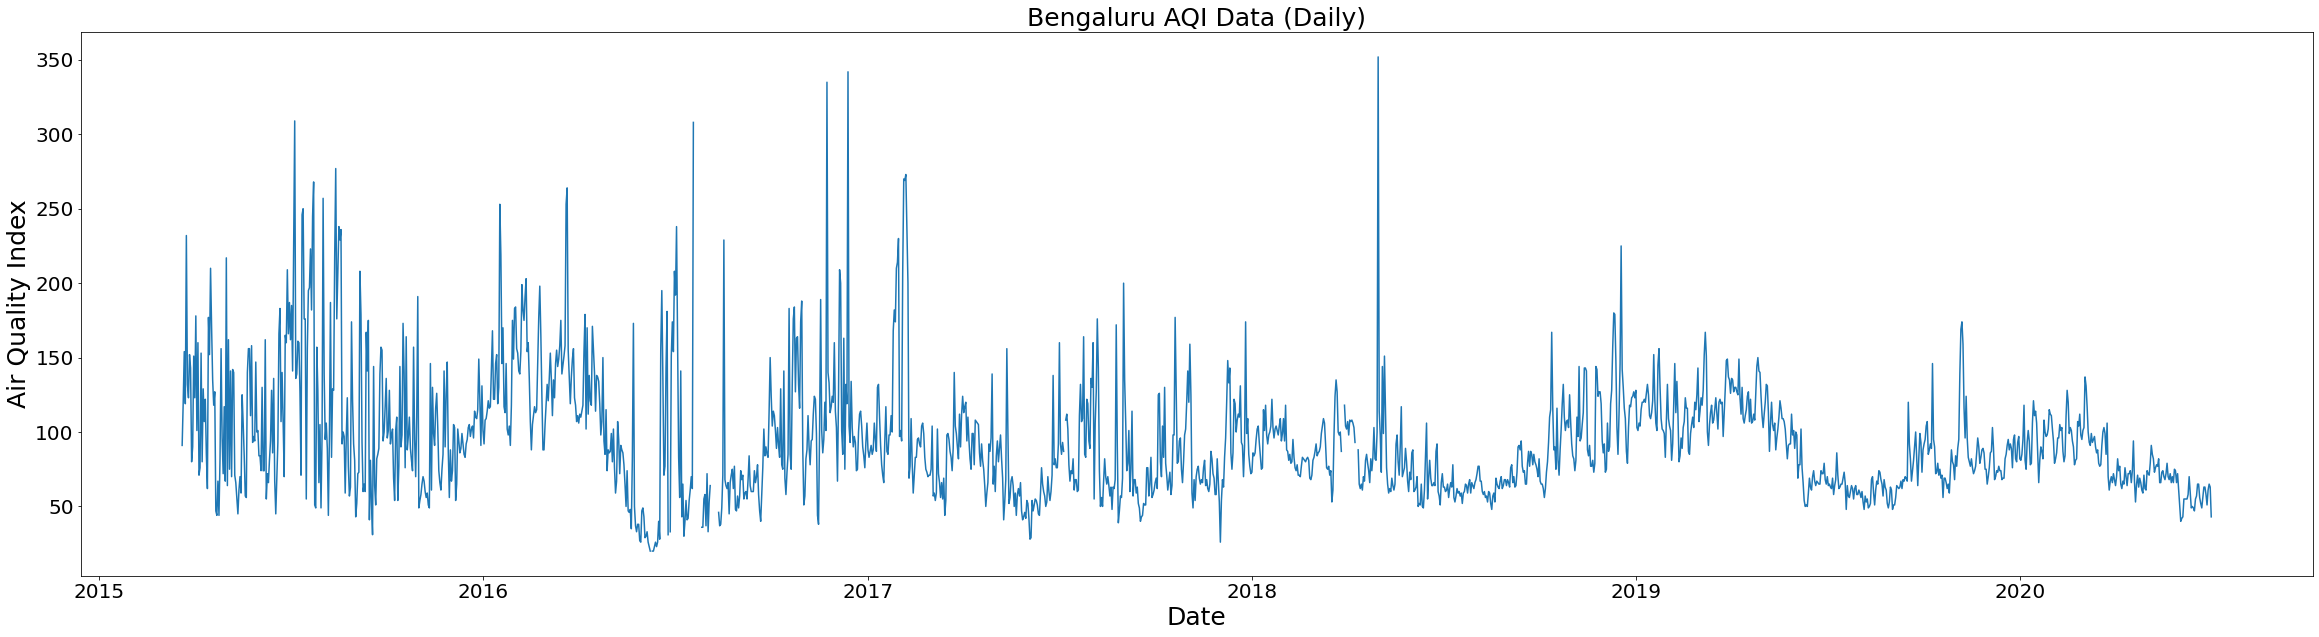

In [41]:
# Plotting all the datapoints using MatPlotLib
fig = plt.figure(figsize = (40, 10))
plt.plot(final_data.index,final_data.AQI)
title = state_name + ' AQI Data (Daily)'
plt.title(title, fontsize = 25)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Air Quality Index", fontsize = 25)
plt.tick_params(labelsize=20)
plt.savefig("Data.png",dpi=300)
plt.show()


<Figure size 2160x720 with 0 Axes>

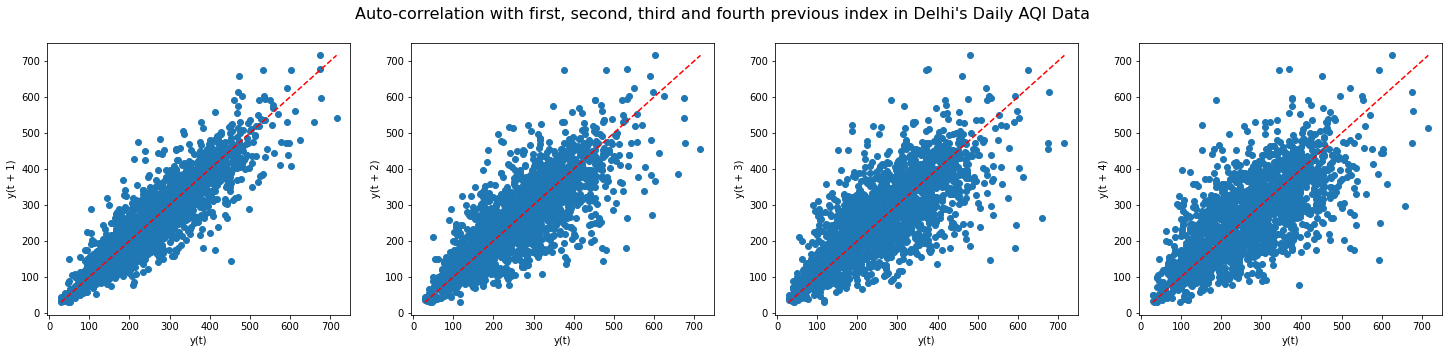

In [7]:
# Plotting Autocorrelation Scatterplots
from pandas.plotting import lag_plot
fig = plt.figure(figsize = (30, 10))

fig, ax_ = plt.subplots(1, 4, figsize = (25, 5))
aqi_serie = final_data.AQI
for i in range(4):
    
    lag_plot((aqi_serie), lag = i+1, ax = ax_[i]);
    ax_[i].plot([min(aqi_serie), max(aqi_serie)], [min(aqi_serie), max(aqi_serie)],'--', color = 'red' )

fig.suptitle('Auto-correlation with first, second, third and fourth previous index in ' + state_name + '\'s Daily AQI Data', fontsize = 16);
# plt.savefig("Data.png", dpi=300)

In [8]:
# Making data continuous using interpolation through mean, so that it can be used in further time series forecasting

final_data['AQI'] = final_data['AQI'].fillna(final_data['AQI'].mean(axis=0))
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     2009 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


<Figure size 7200x2160 with 0 Axes>

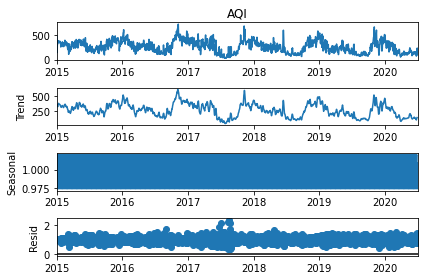

In [9]:
# Seasonal Decompose using statsmodels library.

from statsmodels.tsa.seasonal import seasonal_decompose

AQI_data = final_data['AQI']
fig = plt.figure(figsize = (100,30))
result = seasonal_decompose(AQI_data, model='multiplicative')
result.plot();

In [10]:
# RESAMPLING DATA TO MONTHLY FORMAT
# MS is code for resampling Monthly

seasonal_data = final_data
seasonal_data = seasonal_data.resample(rule='MS').mean()
seasonal_data

,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
...,...
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161


<Figure size 2160x2160 with 0 Axes>

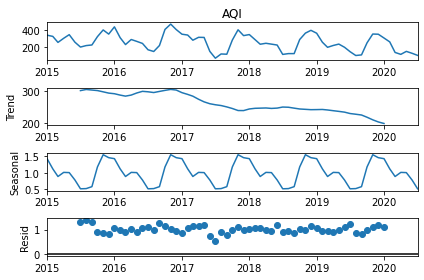

In [11]:
monthly_data = seasonal_data['AQI']
fig = plt.figure(figsize = (30,30))
result = seasonal_decompose(monthly_data, model='multiplicative')
result.plot();

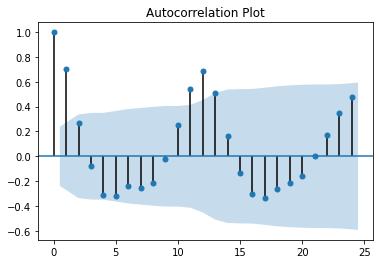

In [12]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(monthly_data, lags=24, title="Autocorrelation Plot")
plt.savefig("Data.png",dpi=300)
plt.show()

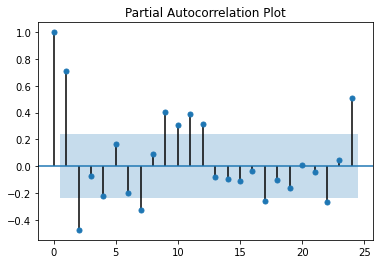

In [13]:
# AUTOCORRELATION PLOT (24 Months rather than 12 for reference)
fig = tsaplots.plot_pacf(monthly_data, lags=24, title="Partial Autocorrelation Plot")
plt.savefig("Data.png",dpi=300)
plt.show()

In [14]:
# Splitting Before and After Lockdown values

AQI_beforeLockdown = monthly_data['2015-01-01':'2020-03-25']
AQI_afterLockdown = monthly_data['2020-03-26':'2020-07-01']

**MODELS COME INTO PLAY**

In [15]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored

In [ ]:
# Finding Parameters of the ARIMA Model using Auto_Arima
auto_arima(y=monthly_data,start_p=0,start_P=0,start_q=0,start_Q=0,seasonal=True, m=12)

In [ ]:
# TEST TRAIN SPLIT
train_size = int(len(AQI_beforeLockdown) * 0.8)
X_train = AQI_beforeLockdown[:train_size+1] #from 2015-2018
X_test = AQI_beforeLockdown[train_size+1:len(monthly_data)-1]# july 2018-june 2019

In [ ]:
X_test

In [ ]:
# TRAINING FINAL MODEL

model=SARIMAX(X_train,order=(1,0,0),seasonal_order=(1,0,1,12),)
results=model.fit()
results.summary()

In [ ]:
# Making Predictions on Test Dataset
predictionsX = results.predict(start=list(X_test.index)[0], end=list(X_test.index)[-1], typ='levels').rename('Predictions')

In [ ]:
# Visualizing Results
predictionsX.plot(legend=True, color = 'red')
AQI_2020 = monthly_data['2019-01-01':'2020-03-30']
AQI_2020.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI",color = 'gray');
X_test.plot(color = 'blue');
plt.ylabel("AQI")
plt.xlabel("Date")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error,mean_poisson_deviance,mean_gamma_deviance
import math
RMSE=np.sqrt(mean_squared_error(predictionsX,X_test))
print('Root Mean Squared Error: ', RMSE)
print('Mean AQI:',X_test.mean())
forecast_errors = [X_test[i]-predictionsX[i] for i in range(len(X_test))]
bias = sum(forecast_errors) * 1.0/len(X_test)
print('Bias: %f' % bias)
mse = mean_squared_error(X_test, predictionsX)
print('MSE: '+str(mse))
mae = mean_absolute_error(X_test, predictionsX)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(X_test, predictionsX))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictionsX - X_test)/np.abs(X_test))
print('MAPE: '+str(mape))
r2score=r2_score(X_test, predictionsX)
print('r2score: '+str(r2score))
explainedVariance_score=explained_variance_score(X_test, predictionsX)
print('explainedVariance_score: '+str(explainedVariance_score))
me=max_error(X_test, predictionsX)
print('me: '+str(me))
mpd=mean_poisson_deviance(X_test, predictionsX)
print('mpd: '+str(mpd))
mgd=mean_gamma_deviance(X_test, predictionsX)
print('mgd: '+str(mgd))

In [ ]:
# Graph for Actual vs Predicted in Covid
after_covid_months = monthly_data[63:]
predictions = results.predict(start=63, end=68, typ='levels').rename('Predictions')
predictions.plot(legend=True)
after_covid_months.plot(legend=True,figsize=(12,8),grid=True,title="Delhi AQI Prediction vs Actual and Future Forecast");
plt.ylabel("AQI")
plt.xlabel("Date")

In [ ]:
city_name = ['Delhi', 'Hyderabad', 'Bengaluru', 'Chennai']
city_day['Date'] = pd.to_datetime(city_day['Date'])
df = pd.DataFrame(columns=['City', 'Year', 'Mean'])

for city in city_name:
  for i in range(2015,2021):
    blr = city_day[(city_day.AQI.notnull()) & (city_day.City == city)][['Date','City','AQI']]
    blr_marchtojuly = blr[(blr["Date"].map(lambda x: x.month in [3,4,5,6,7])) & (blr["Date"].map(lambda x: x.year in [i])) & (blr["Date"].map(lambda x: x >= pd.to_datetime(f'25-03-{x.year}')))]
    # print('Mean AQI for March to July for City '+city+ ' - Year ' + str(i) + ' is ' + str(blr_marchtojuly.mean()))
    df = df.append({'City': city, 'Year': i, 'Mean': float(blr_marchtojuly.mean())}, ignore_index=True)

In [ ]:
df

In [ ]:
# Group the data by city and calculate the mean AQI value for 2015-2019
mean_2015_2019 = df[df['Year'] != 2020].sort_values('City')
mean_2015_2019 = mean_2015_2019.groupby('City')['Mean'].mean()
print(mean_2015_2019)
# Extract the data for 2020
df_2020 = df[df['Year'] == 2020].sort_values('City')

# Set the x-axis labels
x_labels = df_2020['City'].tolist()

# Set the bar width
bar_width = 0.4

# Calculate the x-axis positions for the bars
x_2015_2019 = [x for x in range(len(x_labels))]
x_2020 = [x + bar_width for x in x_2015_2019]
plt.figure(figsize=(10,6))
plt.bar(x_2015_2019, mean_2015_2019, width=bar_width, label='2015-2019')
plt.bar(x_2020, df_2020['Mean'], width=bar_width, label='2020')
plt.xticks([x + bar_width/2 for x in x_2015_2019], x_labels)
plt.ylabel('Mean AQI')
plt.title('Side by Side Comparison of Yearly Mean AQI Values in Absence of COVID vs 2020 - In Presence of COVID Lockdown')
plt.legend()
plt.show()
